## height data

I found growth curves for girls and boys in Israel:

* [url girls](https://www.gov.il/BlobFolder/reports/kidsandmatures-curves/he/subjects_children-adolescents_g-height-age-5-19.pdf), <a href="/archive/data/subjects_children-adolescents_g-height-age-5-19.pdf" download>pdf girls</a>
* [url boys](https://www.gov.il/BlobFolder/reports/kidsandmatures-curves/he/subjects_children-adolescents_B-height-age-5-19.pdf), <a href="/archive/data/subjects_children-adolescents_B-height-age-5-19.pdf" download>pdf boys</a>
* [url both](https://briuton.co.il/4587/%D7%A2%D7%A7%D7%95%D7%9E%D7%95%D7%AA-%D7%92%D7%93%D7%99%D7%9C%D7%94-%D7%91%D7%A0%D7%99%D7%9D-%D7%95%D7%91%D7%A0%D7%95%D7%AA/), <a href="/archive/data/boys_chart3.png" download>png boys</a>, <a href="/archive/data/girls_chart1.png" download>png girls</a>.

For example, see this:

![](/archive/data/boys_chart3.png)


I used the great online resource [Web Plot Digitizer v4](https://apps.automeris.io/wpd4/) to extract the data from the images files. I captured the percentiles for boys and girls for ages 14 and 19:

* <a href="/archive/data/height_boys_14.csv" download>csv boys 14</a>
* <a href="/archive/data/height_boys_19.csv" download>csv boys 19</a>
* <a href="/archive/data/height_girls_14.csv" download>csv girls 14</a>
* <a href="/archive/data/height_girls_19.csv" download>csv boys 19</a>

Let's plot this data as cdfs.

In [7]:
#| code-summary: "import libraries"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
from scipy.optimize import curve_fit
from scipy.special import erf
# %matplotlib widget

In [8]:
#| code-summary: "load data into dataframes"
cdf19_boys = pd.read_csv('../archive/data/height_boys_19.csv',)
cdf14_boys = pd.read_csv('../archive/data/height_boys_14.csv',)
cdf19_girls = pd.read_csv('../archive/data/height_girls_19.csv',)
cdf14_girls = pd.read_csv('../archive/data/height_girls_14.csv',)

In [9]:
cdf19_boys

,percentile,height
0,0.1,153.971963
1,3.0,162.850467
2,5.0,164.638070
3,10.0,167.587131
4,15.0,169.158879
5,25.0,171.715818
6,50.0,176.729223
7,75.0,181.447721
8,85.0,184.112150
9,90.0,185.871314


[Text(0.5, 0, 'height (cm)'),
 Text(0, 0.5, 'percentile'),
 Text(0.5, 1.0, 'Height CDFs, Israel')]

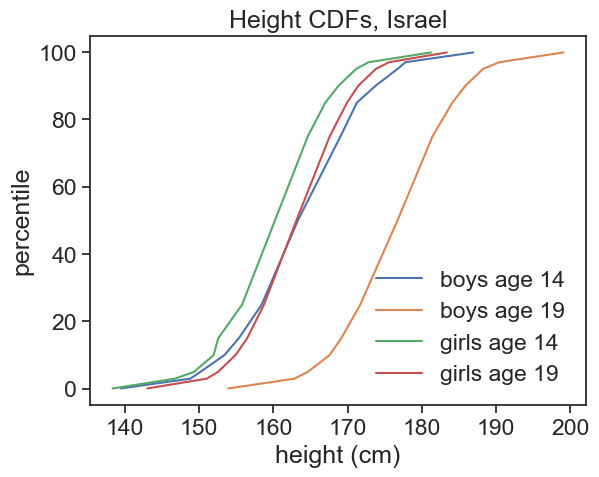

In [10]:
#| code-summary: "plot cdfs"
fig, ax = plt.subplots()
ax.plot(cdf14_boys['height'], cdf19_boys['percentile'], label="boys age 14")
ax.plot(cdf19_boys['height'], cdf19_boys['percentile'], label="boys age 19")
ax.plot(cdf14_girls['height'], cdf19_girls['percentile'], label="girls age 14")
ax.plot(cdf19_girls['height'], cdf19_girls['percentile'], label="girls age 19")
ax.legend(frameon=False)
ax.set(xlabel='height (cm)',
       ylabel='percentile',
       title='Height CDFs, Israel')

I would like to extract from the data the full cdf, for any height. I'll try to fit each dataset to the cumulative distribution function of the gaussian (normal) distribution:
$$
\Phi(x) = \frac{1}{2} \left( 1 + \text{erf}\left(\frac{x - \mu}{\sigma \sqrt{2}}\right) \right)
$$
where $\mu$ is the mean and $\sigma$ is the standard deviation of the distribution. The error function $\text{erf}$ is a sigmoid function, which is a good approximation for the cdf of the normal distribution.


In [11]:
#| code-summary: "fit data to erf function"
def erf_model(x, mu, sigma):
    return 50 * (1 + erf((x - mu) / (sigma * np.sqrt(2))) )
# initial guess for parameters: [mu, sigma]
p0 = [150, 20]
# fit the model

params14_boys, _ = curve_fit(erf_model, cdf14_boys['height'], cdf14_boys['percentile'], p0=p0)
params19_boys, _ = curve_fit(erf_model, cdf19_boys['height'], cdf19_boys['percentile'], p0=p0)
params14_girls, _ = curve_fit(erf_model, cdf14_girls['height'], cdf14_girls['percentile'], p0=p0)
params19_girls, _ = curve_fit(erf_model, cdf19_girls['height'], cdf19_girls['percentile'], p0=p0)

# Calculate R-squared
def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Predicted values
y_pred_14_boys = erf_model(cdf14_boys['height'], *params14_boys)
y_pred_19_boys = erf_model(cdf19_boys['height'], *params19_boys)
y_pred_14_girls = erf_model(cdf14_girls['height'], *params14_girls)
y_pred_19_girls = erf_model(cdf19_girls['height'], *params19_girls)
# R-squared value
r2_14_boys = calculate_r2(cdf14_boys['percentile'], y_pred_14_boys)
r2_19_boys = calculate_r2(cdf19_boys['percentile'], y_pred_19_boys)
r2_14_girls = calculate_r2(cdf14_girls['percentile'], y_pred_14_girls)
r2_19_girls = calculate_r2(cdf19_girls['percentile'], y_pred_19_girls)

print(f"Boys, age 14: μ={params14_boys[0]:.0f}cm, σ={params14_boys[1]:.0f}cm, R-squared={r2_14_boys:.4e}")
print(f"Boys, age 19: μ={params19_boys[0]:.0f}cm, σ={params19_boys[1]:.0f}cm, R-squared={r2_19_boys:.4e}")
print(f"Gilrs, age 14: μ={params14_girls[0]:.0f}cm, σ={params14_girls[1]:.0f}cm, R-squared={r2_14_girls:.4e}")
print(f"Girls, age 19: μ={params19_girls[0]:.0f}cm, σ={params19_girls[1]:.0f}cm, R-squared={r2_19_girls:.4e}")

Boys, age 14: μ=164cm, σ=8cm, R-squared=9.9975e-01
Boys, age 19: μ=177cm, σ=7cm, R-squared=9.9996e-01
Gilrs, age 14: μ=160cm, σ=7cm, R-squared=9.9966e-01
Girls, age 19: μ=163cm, σ=6cm, R-squared=9.9998e-01


[Text(0.5, 0, 'height (cm)'),
 Text(0, 0.5, 'percentile'),
 Text(0.5, 1.0, 'Height CDFs, Israel')]

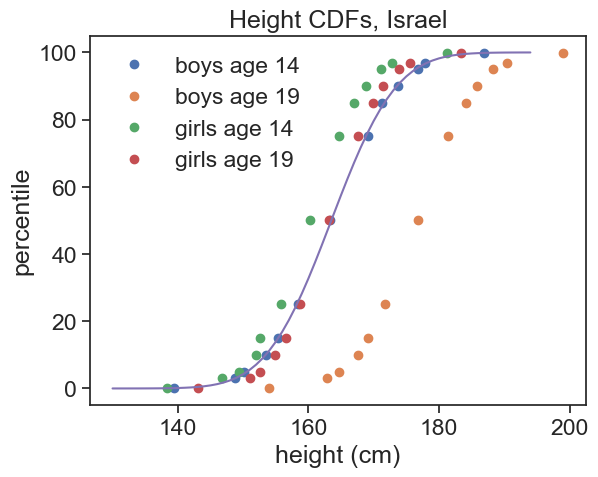

In [12]:
#| code-summary: "plot cdfs"
fig, ax = plt.subplots()
ax.plot(cdf14_boys['height'], cdf19_boys['percentile'], label="boys age 14", ls='None', marker='o')
ax.plot(cdf19_boys['height'], cdf19_boys['percentile'], label="boys age 19", ls='None', marker='o')
ax.plot(cdf14_girls['height'], cdf19_girls['percentile'], label="girls age 14", ls='None', marker='o')
ax.plot(cdf19_girls['height'], cdf19_girls['percentile'], label="girls age 19", ls='None', marker='o')

h = np.arange(130, 195, 1)
cdf_fit_boys14 = erf_model(h, *params14_boys)

ax.plot(h, cdf_fit_boys14)

ax.legend(frameon=False, loc="upper left")
ax.set(xlabel='height (cm)',
       ylabel='percentile',
       title='Height CDFs, Israel')